In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.init as init
from sklearn.model_selection import KFold
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
from utils.ESPF_drug2emb import drug2emb_encoder
from utils.Model import Omics_DrugESPF_Model
from utils.split_data_id import split_id
from utils.create_dataloader import OmicsDrugDataset
from utils.train import train, evaluation
from utils.correlation import correlation_func
from utils.plot import loss_curve, correlation_density,Density_Plot_of_AUC_Values
from utils.tools import get_data_value_range,set_seed,get_vram_usage
from utils.plot import loss_curve
from utils.Loss import MAE_RMSEmean
from utils.config1 import *

In [2]:
import os
print(os.getcwd())

/root/DeepTTA


pip install subword-nmt seaborn lifelines openpyxl matplotlib scikit-learn openTSNE

In [3]:
test_dataset = True # True:small dataset, False: full dataset
test = True

In [4]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

if test is True:
    batch_size = 3
    num_epoch = 2
    print("batch_size",batch_size,"num_epoch:",num_epoch)
# print("include_omics",include_omics)
# print("dense_layer_dim",dense_layer_dim)

hyperparameter_print = f' omics_dict ={omics_dict}\n omics_files ={omics_files}\n TCGA_pretrain_weight_path_dict ={TCGA_pretrain_weight_path_dict}\n seed ={seed}\n filename ={filename}\n  model_name ={model_name}\n splitType ={splitType}\n valueMultiply ={valueMultiply}\n omics_encode_dim ={[(omic_type,omics_encode_dim_dict[omic_type]) for omic_type in include_omics]}\n max_drug_len ={max_drug_len}\n drug_embedding_feature_size ={drug_embedding_feature_size}\n Transformer ={Transformer}\n intermediate_size ={intermediate_size}\n num_attention_heads ={num_attention_heads}\n attention_probs_dropout_prob ={attention_probs_dropout_prob}\n hidden_dropout_prob ={hidden_dropout_prob}\n drug_encode_dims ={drug_encode_dims}\n activation_func = {activation_func}\n activation_func_final = {activation_func_final}\n dense_layer_dim = {dense_layer_dim}\n batch_size = {batch_size}\n num_epoch = {num_epoch}\n patience = {patience}\n warmup_iters = {warmup_iters}\n Decrease_percent = {Decrease_percent}\n continuous ={continuous}\n learning_rate = {learning_rate}\n criterion ={criterion}\n'

hyperparameter_folder_part = (f'Model{model_name}_{splitType}_AUC*{valueMultiply}_OmicsDim{[(omic_type,omics_encode_dim_dict[omic_type]) for omic_type in include_omics]}Dmax{max_drug_len}Demb{drug_embedding_feature_size}Tranformer{Transformer}_InterSZ{intermediate_size}Head{num_attention_heads}AttnDropR{attention_probs_dropout_prob}HiddenDropR{hidden_dropout_prob}DrugDim{drug_encode_dims}').translate(translation_table)
# print(hyperparameter_folder_part)
hyperparametersave = (f'ActF{activation_func}ActFFinl{activation_func_final}MLPDim{dense_layer_dim}BSZ{batch_size}Epoc{num_epoch}Patien{patience}warmup{warmup_iters}Decre%{Decrease_percent}LR{learning_rate}{criterion}.pt').translate(translation_table)
# print(hyperparametersave)

Training on device cuda.
batch_size 3 num_epoch: 2


In [5]:
# Function to set the seed for reproducibility
set_seed(seed)

In [6]:
# include_omics = ['mut',"exp"]
# print([print(j) for j in omics_encode_dim_dict[i] for i in include_omics])
# # f'(1000_100_50)(1000_100_50)'

In [7]:
for omic_type in include_omics:
    # Read the file
    omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep='\t', index_col=0)

    if test_dataset is True:
        # Specify the index as needed
        omics_data_dict[omic_type] = omics_data_dict[omic_type][:76]  # Adjust the row selection as needed
    omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32)
    omics_numfeaetures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]
    print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeaetures_dict[omic_type])

mut tensor shape: torch.Size([76, 6009])
mut num_features 6009


In [8]:
#load data
# data_mut, gene_names_mut,ccl_names_mut  = load_ccl("/root/data/CCLE/CCLE_match_TCGAgene_PRISMandEXPsample_binary_mutation_476_6009.txt")
drug_df= pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/MACCS(Secondary_Screen_treatment_info)_union_NOrepeat.csv", sep=',', index_col=0)
AUC_df = pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NOrepeat.csv", sep=',', index_col=0)
# data_AUC_matrix, drug_names_AUC, ccl_names_AUC = load_AUC_matrix(splitType,"/root/Winnie/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted.csv") # splitType = "byCCL" or "byDrug" 決定AUCmatrix要不要轉置
print("drug_df",(np.shape(drug_df)))
print("AUC_df",np.shape(AUC_df))

drug_df (1440, 9)
AUC_df (480, 1440)


In [9]:
# matched AUCfile and omics_data samples
matched_samples = sorted(set(AUC_df.T.columns) & set(list(omics_data_dict.values())[0].T.columns))
print(len(matched_samples))
AUC_df= (AUC_df.T[matched_samples]).T
print("AUC_df",AUC_df.shape)

76
AUC_df (76, 1440)


In [10]:
if test_dataset is True:
    drug_df=drug_df[:42]
    AUC_df=AUC_df.iloc[:76,:42]
print("drug_df",drug_df.shape)
print("AUC_df",AUC_df.shape)

drug_df (42, 9)
AUC_df (76, 42)


In [11]:
# 檢查有無重複的SMILES
drug_smiles =drug_df["smiles"] # 
print("drug_smiles.shape",drug_smiles.shape)
drug_names =drug_df.index
print("(drug_smiles.unique()).shape",(drug_smiles.unique()).shape)
# 挑出重複的SMILES
duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]
print("duplicate drug",duplicate)


drug_smiles.shape (42,)
(drug_smiles.unique()).shape (42,)
duplicate drug Series([], Name: smiles, dtype: object)


In [12]:
#ESPF
vocab_path = "./dataset/ESPF/drug_codes_chembl_freq_1500.txt" # token
sub_csv = pd.read_csv("./dataset/ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency

# smile_encode = pd.Series(drug_smiles.unique()).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))# 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
smile_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
# uniq_smile_dict = dict(zip(drug_smiles.unique(),smile_encode))# zip drug_smiles和其subword vector編碼 成字典

# print(type(smile_encode))
# print(smile_encode.shape)
# print(type(smile_encode.index))
print((smile_encode.index.values).shape)

num_ccl = list(omics_data_dict.values())[0].shape[0]
num_drug = smile_encode.shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)

(42,)
num_ccl,num_drug:  76 42


In [13]:
# Convert your data to tensors if they're in numpy
drug_features_tensor = torch.tensor(np.array(smile_encode.values.tolist()), dtype=torch.long)
response_matrix_tensor = torch.tensor(AUC_df.values, dtype=torch.float32)


In [14]:
# randomly split
# 90% for training(10% for validation) and 10% for testing
id_unrepeat_train, id_unrepeat_val, id_unrepeat_test, _ , id_train, id_val, id_test= split_id(num_ccl=num_ccl,num_drug=num_drug,splitType=splitType,repeat=True,kFold=False)

id_unrepeat_train (60,)
id_unrepeat_val (8,)
id_unrepeat_test (8,)
id_unrepeat_train_val (68,)
id_train.shape (2520,)
id_val.shape (336,)
id_test.shape (336,)


In [15]:
set_seed(seed)
dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)

train_dataset = Subset(dataset, id_train.tolist())
val_dataset = Subset(dataset, id_val.tolist())
test_dataset = Subset(dataset, id_test.tolist())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
%%time
# train
# Init the neural network 
set_seed(seed)
model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeaetures_dict, max_drug_len,
                        TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict).to(device=device)
num_param = sum([param.nelement() for param in model.parameters()])
print("Number of parameter: %.2fK" % (num_param/1e3))

optimizer = optim.Adam(model.parameters(), lr=learning_rate)# Initialize optimizer

best_epoch, best_weight, best_val_loss, train_epoch_loss_list, val_epoch_loss_list,_,attention_score_matrix, gradient_norms = train( model, activation_func_final,
    optimizer,      batch_size,      num_epoch,      patience,      warmup_iters,      Decrease_percent,    continuous,
    learning_rate,      criterion,      valueMultiply,      train_loader,      val_loader,
    device,Transformer=Transformer,      seed=42, kfoldCV = None)

print("best Epoch : ",best_epoch,"best_val_loss : ",best_val_loss," batch_size : ",batch_size,
        "learning_rate : ",learning_rate," warmup_iters :" ,warmup_iters  ," with Decrease_percent : ",Decrease_percent )

# Saving the model weughts
hyperparameter_folder_path = f'./results/{filename}_BestValLoss{best_val_loss:.7f}BestEpo{best_epoch}{hyperparameter_folder_part}' # /root/Winnie/PDAC
os.makedirs(hyperparameter_folder_path, exist_ok=True)
save_path = os.path.join(hyperparameter_folder_path, hyperparametersave)
torch.save(best_weight, save_path)

State_dict for Sequential(
  (0): Linear(in_features=6009, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=100, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=100, out_features=50, bias=True)
) loaded successfully.
Number of parameter: 17635.40K

 Transformer is not applied 



/root/DeepTTA/utils/Model.py:364: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_weight = torch.tensor(mask, dtype=torch.float32).unsqueeze(1).repeat(1, 50, 1)# (bsz, 50)->(bsz,50,50)


best Epoch :  1 best_val_loss :  0.003234280913393736  batch_size :  3 learning_rate :  0.0001  warmup_iters : 150  with Decrease_percent :  0.99
CPU times: user 19.5 s, sys: 958 ms, total: 20.5 s
Wall time: 23.6 s


In [17]:
import json
epoch_loss_dict = {"train_epoch_loss_list": train_epoch_loss_list, "val_epoch_loss_list": val_epoch_loss_list}
json_data = json.dumps(epoch_loss_dict, indent=0)
with open(f"{hyperparameter_folder_path}/epoch_loss.json", "w") as json_file:
    json_file.write(json_data)
#---------------------------------

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

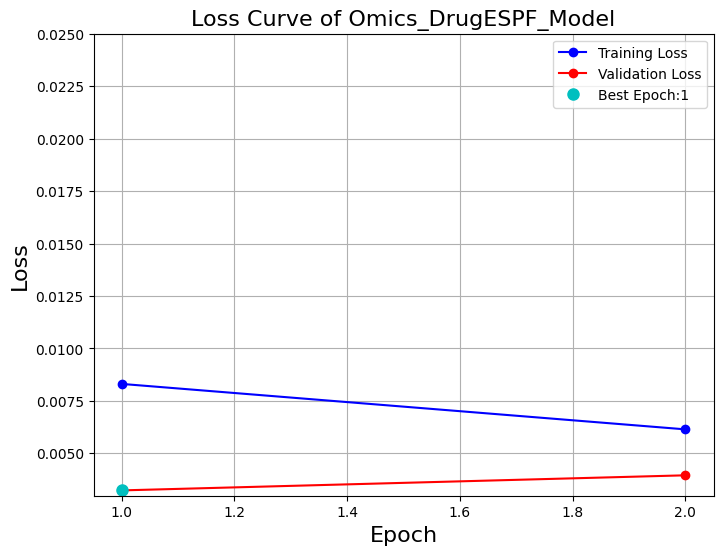

In [18]:
loss_curve(model_name, train_epoch_loss_list, val_epoch_loss_list, best_epoch, best_val_loss,hyperparameter_folder_path, ylim_top=0.025)


In [ ]:
fig= plt.figure(figsize=(8, 6))
plt.plot(gradient_norms)
plt.title("Gradient Norms Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")    
fig.savefig(f'{hyperparameter_folder_path}/Gradient Norms Over Epochs')

In [19]:
# Evaluation
#Evaluation on best fold best split id (train, val) with best_fold_best_weight 
set_seed(seed)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Evaluation on the train set
model.load_state_dict(best_weight)  
model = model.to(device=device)
epoch = None
train_loss, train_targets, train_outputs = evaluation(model, activation_func_final, epoch, num_epoch, val_epoch_loss_list, criterion, valueMultiply, train_loader, device, Transformer=Transformer, correlation='train', kfoldCV = None)
# Evaluation on the validation set
model.load_state_dict(best_weight)  
model = model.to(device=device)
val_loss, val_targets, val_outputs = evaluation(model, activation_func_final, epoch, num_epoch, val_epoch_loss_list, criterion, valueMultiply, val_loader, device, Transformer=Transformer, correlation='val', kfoldCV = None)
# Evaluation on the test set
model.load_state_dict(best_weight)
model = model.to(device=device)
test_loss, test_targets, test_outputs = evaluation(model, activation_func_final, epoch, num_epoch, val_epoch_loss_list, criterion, valueMultiply, test_loader, device, Transformer=Transformer, correlation='test', kfoldCV = None)

predicted_AUC (1419,)
GroundTruth_AUC (1419,)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

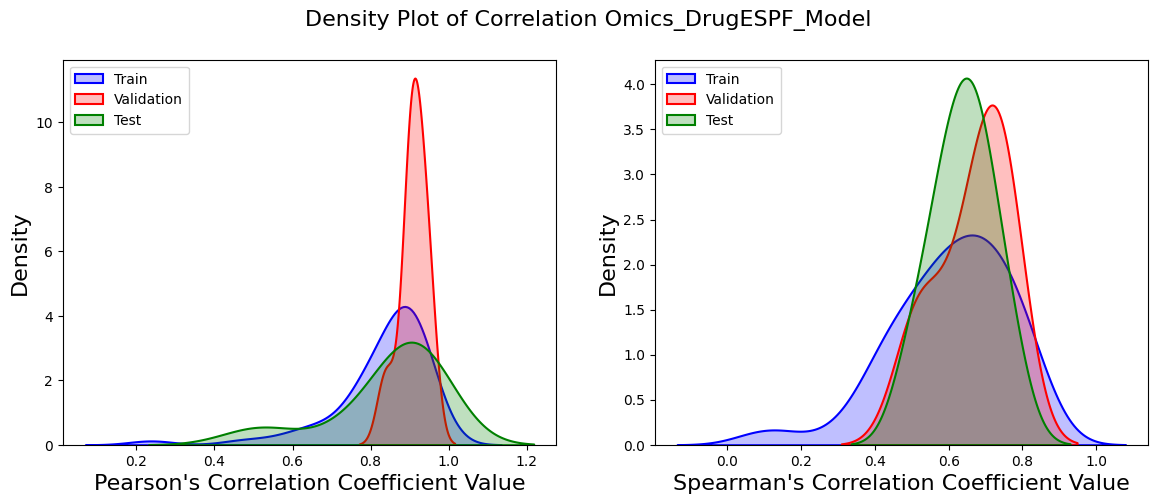

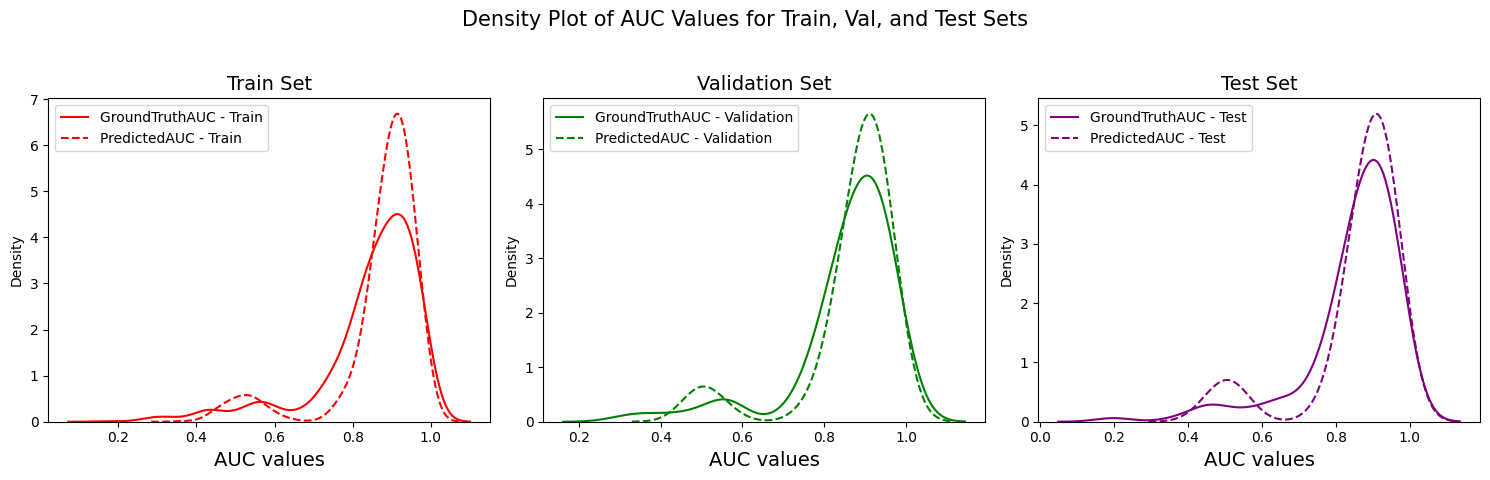

In [20]:
# Correlation
train_pearson, train_spearman = correlation_func(splitType, AUC_df.values,AUC_df.index,AUC_df.columns,id_unrepeat_train,train_targets,train_outputs)
# print("\n")
# print("val set"+"="*20)
# print("val set"+"="*20)
val_pearson, val_spearman = correlation_func(splitType, AUC_df.values,AUC_df.index,AUC_df.columns,id_unrepeat_val,val_targets,val_outputs)
# print("\n")
# print("test set"+"="*20)
# print("test set"+"="*20)
test_pearson, test_spearman = correlation_func(splitType, AUC_df.values,AUC_df.index,AUC_df.columns,id_unrepeat_test,test_targets,test_outputs)

#plot correlation_density
correlation_density(model_name,train_pearson,val_pearson,test_pearson,train_spearman,val_spearman,test_spearman, hyperparameter_folder_path)

# plot GroundTruth AUC and predicted AUC distribution
predicted_AUC = np.concatenate(train_outputs + val_outputs + test_outputs).tolist()
# print(predicted_AUC[:10])
print("predicted_AUC",np.array(predicted_AUC).shape)
GroundTruth_AUC = np.concatenate(train_targets + val_targets + test_targets).tolist()
print("GroundTruth_AUC",np.array(GroundTruth_AUC).shape)
# print(GroundTruth_AUC[:10])

datas = [(train_targets, train_outputs, 'Train', 'red'),
                (val_targets, val_outputs, 'Validation', 'green'),
                (test_targets, test_outputs, 'Test', 'purple')]
# plot Density_Plot_of_AUC_Values of train val test datasets
Density_Plot_of_AUC_Values(datas,hyperparameter_folder_path)


In [ ]:
output_file = f"{hyperparameter_folder_path}/result_performance.txt"
with open(output_file, "w") as file:
    # data range
    get_data_value_range(GroundTruth_AUC,"GroundTruth_AUC", file=file)
    get_data_value_range(predicted_AUC,"predicted_AUC", file=file)
    # print hyperparameter and result
    print(filename, file=file)
    print(hyperparameter_print, file=file)
    print('best epoch: ',best_epoch, file=file)
    print(f'Evaluation Training Loss: {train_loss:.6f}', file=file)
    print(f'Evaluation validation Loss: {val_loss:.6f}', file=file)
    print(f'Evaluation Test Loss: {test_loss:.6f}', file=file)
# Pearson and Spearman statistics
    for name, pearson in [("Train", train_pearson),
                                    ("Validation", val_pearson),
                                    ("Test", test_pearson)]:
        print(f"Mean {name} Pearson {model_name}: {np.mean(pearson):.6f}", file=file)
        print(f"Median {name} Pearson {model_name}: {np.median(pearson):.6f}", file=file)
        print(f"Mode {name} Pearson {model_name}: {stats.mode(np.round(pearson,2))[0]}, count={stats.mode(np.round(pearson,2))[1]}", file=file)
    for name, spearman in [("Train", train_spearman),
                                    ("Validation", val_spearman),
                                    ("Test", test_spearman)]:
        print(f"Mean {name} Spearman {model_name}: {np.mean(spearman):.6f}", file=file)
        print(f"Median {name} Spearman {model_name}: {np.median(spearman):.6f}", file=file)
        print(f"Mode {name} Spearman {model_name}: {stats.mode(np.round(spearman,2))[0]}, count={stats.mode(np.round(spearman,2))[1]}", file=file)
    for name, pearson in [("Train", train_pearson),
                                    ("Validation", val_pearson),
                                    ("Test", test_pearson)]:
        print(f"Mean Median Mode {name} Pearson {model_name}:\t{np.mean(pearson):.6f}\t{np.median(pearson):.6f}\t{stats.mode(np.round(pearson,2))}", file=file)
    for name, spearman in [("Train", train_spearman),
                                    ("Validation", val_spearman),
                                    ("Test", test_spearman)]:
        print(f"Mean Median Mode {name} Pearson {model_name}:\t{np.mean(spearman):.6f}\t{np.median(spearman):.6f}\t{stats.mode(np.round(spearman,2))}", file=file)
    print("Output saved to:", output_file)

# old-----------------------------------------------------------------------
# print(f"Mean train_pearson {model_name}: ",np.mean(train_pearson))
# print(f"Median train_pearson {model_name}: ",np.median(train_pearson))
# print(f"Mode train_pearson {model_name}: ",stats.mode(np.round(train_pearson,2))[0],",count=",stats.mode(np.round(train_pearson,2))[1])
# print(f"Mean val_pearson {model_name}: ",np.mean(val_pearson))
# print(f"Median val_pearson {model_name}: ",np.median(val_pearson))
# print(f"Mode val_pearson {model_name}: ",stats.mode(np.round(val_pearson,2))[0],",count=",stats.mode(np.round(val_pearson,2))[1])
# print(f"Mean test_pearson {model_name}: ",np.mean(test_pearson))
# print(f"Median test_pearson {model_name}: ",np.median(test_pearson))
# print(f"Mode test_pearson {model_name}: ",stats.mode(np.round(test_pearson,2))[0],",count=",stats.mode(np.round(test_pearson,2))[1])
# print(f"Mean train_spearman {model_name}: ",np.mean(train_spearman))
# print(f"Median train_spearman {model_name}: ",np.median(train_spearman))
# print(f"Mode train_spearman {model_name}: ",stats.mode(np.round(train_spearman,2))[0],",count=",stats.mode(np.round(train_spearman,2))[1])
# print(f"Mean val_spearman {model_name}: ",np.mean(val_spearman))
# print(f"Median val_spearman {model_name}: ",np.median(val_spearman))
# print(f"Mode val_spearman {model_name}: ",stats.mode(np.round(val_spearman,2))[0],",count=",stats.mode(np.round(val_spearman,2))[1])
# print(f"Mean test_spearman {model_name}: ",np.mean(test_spearman))
# print(f"Median test_spearman {model_name}: ",np.median(test_spearman))
# print(f"Mode test_spearman {model_name}: ",stats.mode(np.round(test_spearman,2))[0],",count=",stats.mode(np.round(test_spearman,2))[1])
# print(f"Mean Median Mode train_pearson {model_name}: ",np.mean(train_pearson)," ",np.median(train_pearson)," ",stats.mode(np.round(train_pearson,2)))
# print(f"Mean Median Mode val_pearson {model_name}: ",np.mean(val_pearson)," ",np.median(val_pearson)," ",stats.mode(np.round(val_pearson,2)))
# print(f"Mean Median Mode test_pearson {model_name}: ",np.mean(test_pearson)," ",np.median(test_pearson)," ",stats.mode(np.round(test_pearson,2)))
# print(f"Mean Median Mode train_spearman {model_name}: ",np.mean(train_spearman)," ",np.median(train_spearman)," ",stats.mode(np.round(train_spearman,2)))
# print(f"Mean Median Mode val_spearman {model_name}: ",np.mean(val_spearman)," ",np.median(val_spearman)," ",stats.mode(np.round(val_spearman,2)))
# print(f"Mean Median Mode test_spearman {model_name}: ",np.mean(test_spearman)," ",np.median(test_spearman)," ",stats.mode(np.round(test_spearman,2)))


Output saved to: ./results/ESPF_Train_byCCL_drug_omics_AUC_1fold_BestValLoss0.0032343BestEpo1ModelOmics_DrugESPF_Model_byCCL_AUC1_OmicsDim(mut 1000 100 50)Dmax50Demb128TranformerFalse_InterSZ512Head8AttnDropR0.1HiddenDropR0.1DrugDim1600 400 100/output_information.txt


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CellCrossAttention(nn.Module):
    def __init__(self, drug_dim, cell_dim):
        super(CellCrossAttention, self).__init__()
        self.query_proj = nn.Linear(drug_dim, drug_dim)  # Project drug features to query space
        self.key_proj = nn.Linear(cell_dim, cell_dim)    # Project cell features to key space
        self.value_proj = nn.Linear(cell_dim, cell_dim)  # Project cell features to value space
        self.scale = cell_dim ** -0.5  # Scaling factor for dot product attention

    def forward(self, drug_subunits, cell_subunits):
        # drug_subunits: (batch_size, num_drug_subunits, drug_dim)
        # cell_subunits: (batch_size, num_cell_subunits, cell_dim)

        # Project drug features to query, and cell features to key and value
        queries = self.query_proj(drug_subunits)        # Shape: (batch_size, num_drug_subunits, drug_dim)
        print("drug-queries.shape",queries.shape)
        keys = self.key_proj(cell_subunits)             # Shape: (batch_size, num_cell_subunits, cell_dim)
        print("cell-keys.shape",keys.shape)
        values = self.value_proj(cell_subunits)         # Shape: (batch_size, num_cell_subunits, cell_dim)
        print("cell-values.shape",values.shape)

        # Compute attention scores (scaled dot product)
        attn_scores = torch.matmul(queries, keys.transpose(-2, -1)) * self.scale  # Shape: (batch_size, num_drug_subunits, num_cell_subunits)
        print("attn_scores.shape",attn_scores.shape)
        attn_weights = F.softmax(attn_scores, dim=-1)     # Normalize scores to get attention weights
        print("attn_weights.shape",attn_weights.shape)

        # Compute the final attended output
        attended_values = torch.matmul(values,attn_weights )  # Shape: (batch_size, num_drug_subunits, attn_dim)
        print("attended_values.shape",attended_values.shape)
        
        return attn_weights, attended_values

# Example usage
batch_size = 2
num_drug_subunits, drug_dim = 5, 128
num_cell_subunits, cell_dim = 7, 128

drug_subunits = torch.randn(batch_size, num_drug_subunits, drug_dim)
cell_subunits = torch.randn(batch_size, num_cell_subunits, cell_dim)

cross_attn = CellCrossAttention(drug_dim=drug_dim, cell_dim=cell_dim)
attn_weights, attended_values = cross_attn(drug_subunits, cell_subunits )

print("Attention Weights Shape:", attn_weights.shape)  # (batch_size, num_drug_subunits, num_cell_subunits)
print("Attended Values Shape:", attended_values.shape)  # (batch_size, num_drug_subunits, drug_dim)

drug-queries.shape torch.Size([2, 5, 128])
cell-keys.shape torch.Size([2, 7, 128])
cell-values.shape torch.Size([2, 7, 128])
attn_scores.shape torch.Size([2, 5, 7])
attn_weights.shape torch.Size([2, 5, 7])


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [2, 128] but got: [2, 5].

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CrossAttention(nn.Module):
    def __init__(self, drug_dim, cell_dim, attn_dim):
        super(CrossAttention, self).__init__()
        self.query_proj = nn.Linear(drug_dim, attn_dim)  # Project drug features to query space
        self.key_proj = nn.Linear(cell_dim, attn_dim)    # Project cell features to key space
        self.value_proj = nn.Linear(cell_dim, attn_dim)  # Project cell features to value space
        self.scale = attn_dim ** -0.5  # Scaling factor for dot product attention

    def forward(self, drug_subunits, cell_subunits):
        # drug_subunits: (batch_size, num_drug_subunits, drug_dim)
        # cell_subunits: (batch_size, num_cell_subunits, cell_dim)

        # Project drug features to query, and cell features to key and value
        queries = self.query_proj(drug_subunits)        # Shape: (batch_size, num_drug_subunits, attn_dim)
        keys = self.key_proj(cell_subunits)             # Shape: (batch_size, num_cell_subunits, attn_dim)
        values = self.value_proj(cell_subunits)         # Shape: (batch_size, num_cell_subunits, attn_dim)

        # Compute attention scores (scaled dot product)
        attn_scores = torch.matmul(queries, keys.transpose(-2, -1)) * self.scale  # Shape: (batch_size, num_drug_subunits, num_cell_subunits)
        attn_weights = F.softmax(attn_scores, dim=-1)     # Normalize scores to get attention weights

        # Compute the final attended output
        attended_values = torch.matmul(attn_weights, values)  # Shape: (batch_size, num_drug_subunits, attn_dim)
        
        return attn_weights, attended_values

# Example usage
batch_size = 2
num_drug_subunits, drug_dim = 5, 128
num_cell_subunits, cell_dim = 7, 256
attn_dim = 16

drug_subunits = torch.randn(batch_size, num_drug_subunits, drug_dim)
cell_subunits = torch.randn(batch_size, num_cell_subunits, cell_dim)

cross_attn = CrossAttention(drug_dim=drug_dim, cell_dim=cell_dim, attn_dim=attn_dim)
attn_weights, attended_values = cross_attn(drug_subunits, cell_subunits)

print("Attention Weights Shape:", attn_weights.shape)  # (batch_size, num_drug_subunits, num_cell_subunits)
print("Attended Values Shape:", attended_values.shape)  # (batch_size, num_drug_subunits, attn_dim)


Attention Weights Shape: torch.Size([2, 5, 7])
Attended Values Shape: torch.Size([2, 5, 16])


In [20]:
set_seed(seed)
import torch
from torch import nn
import torch.nn.functional as F
import math
class CrossAttention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, attention_probs_dropout_prob):
        super(CrossAttention, self).__init__()
        if hidden_size % num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (hidden_size, num_attention_heads))
        self.num_attention_heads = num_attention_heads
        self.attention_head_size = int(hidden_size / num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(hidden_size, self.all_head_size)
        self.key = nn.Linear(hidden_size, self.all_head_size)
        self.value = nn.Linear(hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, drugA, drugB, drugA_attention_mask=None):
        # update drugA
        mixed_query_layer = self.query(drugA) # torch.Size([bz, 9, 128])
        mixed_key_layer = self.key(drugB) # torch.Size([bz, 7, 128])
        mixed_value_layer = self.value(drugB) # torch.Size([bz, 7, 128])
        print("mixed_query_layer.shape",mixed_query_layer.shape)
        print("mixed_key_layer.shape",mixed_key_layer.shape)
        print("mixed_value_layer.shape",mixed_value_layer.shape)

        query_layer = self.transpose_for_scores(mixed_query_layer) # torch.Size([bz, 8, 9, 16])
        key_layer = self.transpose_for_scores(mixed_key_layer) # torch.Size([bz, 8, 7, 16])
        value_layer = self.transpose_for_scores(mixed_value_layer) # torch.Size([bz, 8, 7, 16])
        print("query_layer.shape",query_layer.shape)
        print("key_layer.shape",key_layer.shape)
        print("value_layer.shape",value_layer.shape)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2)) # torch.Size([bz, 8, 9, 7])
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        print("attention_scores.shape",attention_scores.shape)

        if drugA_attention_mask == None:
            attention_scores = attention_scores
        else:
            attention_scores = attention_scores + drugA_attention_mask

        attention_probs_0 = nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.dropout(attention_probs_0)

        context_layer = torch.matmul(attention_probs, value_layer) # context_layer:torch.Size([2, 8, 9, 16])
        print("context_layer.shape",context_layer.shape)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous() # torch.Size([2, 9, 8, 16])
        print("context_layer.shape",context_layer.shape)
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,) # torch.Size([2, 9, 128])
        print("new_context_layer_shape",new_context_layer_shape)
        context_layer = context_layer.view(*new_context_layer_shape) # torch.Size([2, 9, 128])
        print("context_layer.shape",context_layer.shape)     

        return context_layer, attention_probs_0

# Example usage
batch_size = 2
num_drug_subunits, drug_dim = 9, 128
num_cell_subunits, cell_dim = 7, 128

drug_subunits = torch.randn(batch_size, num_drug_subunits, drug_dim)
cell_subunits = torch.randn(batch_size, num_cell_subunits, cell_dim)

cross_attn = CrossAttention(hidden_size=128, num_attention_heads=8, attention_probs_dropout_prob=0)
context_layer, attention_probs_0 = cross_attn(drug_subunits, cell_subunits)

context_layer1, attention_probs_1 = cross_attn(cell_subunits, drug_subunits)

print("Attention Weights Shape: attention_probs_0", attention_probs_0.shape)  # (batch_size, head_size, num_drug_subunits, num_cell_subunits)([bz, 8, 9, 7])
# print(attention_probs_0)
print("Attended Values Shape: context_layer", context_layer.shape)  # (batch_size, num_drug_subunits, attn_dim)([2, 9, 128])

print("Attention Weights Shape: attention_probs_1", attention_probs_1.shape)  # (batch_size, head_size, num_drug_subunits, num_cell_subunits)([bz, 8, 9, 7])
# print(attention_probs_1)
print("Attended Values Shape: context_layer1", context_layer1.shape)  # (batch_size, num_drug_subunits, attn_dim)([2, 9, 128])

all_attn = torch.cat((attention_probs_0,attention_probs_1.permute(0, 1, 3, 2).contiguous()),0)  
print(all_attn.shape)


mixed_query_layer.shape torch.Size([2, 9, 128])
mixed_key_layer.shape torch.Size([2, 7, 128])
mixed_value_layer.shape torch.Size([2, 7, 128])
query_layer.shape torch.Size([2, 8, 9, 16])
key_layer.shape torch.Size([2, 8, 7, 16])
value_layer.shape torch.Size([2, 8, 7, 16])
attention_scores.shape torch.Size([2, 8, 9, 7])
context_layer.shape torch.Size([2, 8, 9, 16])
context_layer.shape torch.Size([2, 9, 8, 16])
new_context_layer_shape torch.Size([2, 9, 128])
context_layer.shape torch.Size([2, 9, 128])
mixed_query_layer.shape torch.Size([2, 7, 128])
mixed_key_layer.shape torch.Size([2, 9, 128])
mixed_value_layer.shape torch.Size([2, 9, 128])
query_layer.shape torch.Size([2, 8, 7, 16])
key_layer.shape torch.Size([2, 8, 9, 16])
value_layer.shape torch.Size([2, 8, 9, 16])
attention_scores.shape torch.Size([2, 8, 7, 9])
context_layer.shape torch.Size([2, 8, 7, 16])
context_layer.shape torch.Size([2, 7, 8, 16])
new_context_layer_shape torch.Size([2, 7, 128])
context_layer.shape torch.Size([2, 7

In [21]:
all_attn = [all_attn,all_attn,all_attn]
attn = torch.stack(all_attn, dim=0).cpu().detach().numpy()
print(attn.shape)

(3, 4, 8, 9, 7)
